# Chaotic inflation example

We will demonstrate how to install, and sample over the single field quadratic example:
\begin{equation}
    V(\phi) = \frac{1}{2} m_\phi^2 \phi^2
\end{equation}

## Part 1: Model installion

In [1]:
import os
import numpy as np
import sympy as sym
import pandas as pd
import matplotlib.pyplot as plt
from pytsa.pytrans_setup import Translator
from pytsa.sampler import setup_sampler

from plot_kde import plot_kde  # Helper script for plotting KDEs

-- MPI import successful


In [2]:
# Number of params. We just have the mass parameter for the potential.
n_par = 1

# Number of fields. We just have the field \phi.
n_field = 1

# Define symbolic arrays containing parameters and fields
pars = sym.symarray("p", n_par)
fields = sym.symarray("f", n_field)

# Construct potential. Note how we use the "sym.Rational" method, to construct rational fractions.
# This isn't strictly required, but is good practice when performing symbolic calculations in SymPy,
# as it aids with simplifications.
potential = sym.Rational(1, 2) * pars[0] ** 2 * fields[0] ** 2

In [3]:
potential

f_0**2*p_0**2/2

In [5]:
Translator(n_field, n_par, potential, simplify_metric=True, simplify_potential=True, simplify_covd=True, verbose=True)

-- Derived covariant derivatives loaded from cache
-- Derived covariant derivatives loaded from cache
-- Repacking potentials into flat arrays
   [Thu Aug 25 12:17:24 2022] writing to potential.h
   [Thu Aug 25 12:17:24 2022] performing CSE for V
   [Thu Aug 25 12:17:24 2022] complete in 0.0004547280000002374 sec
   [Thu Aug 25 12:17:24 2022] performing CSE for dV
   [Thu Aug 25 12:17:24 2022] complete in 0.0004833660000000961 sec
   [Thu Aug 25 12:17:24 2022] performing CSE for ddV
   [Thu Aug 25 12:17:24 2022] complete in 0.0001221290000001929 sec
   [Thu Aug 25 12:17:24 2022] performing CSE for dddV
   [Thu Aug 25 12:17:24 2022] complete in 9.997900000069393e-05 sec
   [Thu Aug 25 12:17:24 2022] complete in 0.010173761999999975 sec


In [6]:
try:
    from pytsa.models import chaotic
except ImportError:
    Translator.install("chaotic")
    from pytsa.models import chaotic

## Part 2: Basic model usage

In [7]:
# Doc strings may not be avail via IDE in a "Pythonic" way, but can be accessed with help function, e.g.
help(chaotic.backEvolve)

Help on built-in function backEvolve in module pytsa.models.chaotic:

backEvolve(...)
    backEvolve(Narray: np.ndarray, ics: np.ndarray, params: np.ndarray, tols: np.ndarray, full: bool, tmax=-1, flag_return=False) -> np.ndarray
    
    Compute background evolution for a range of efoldings
    
    Parameters
    ----------
    Narray : np.ndarray,
    1D numpy array corresponding to target efolds for integration.
    ics : numpy array of dtype float of size (1, 2*num_fields),
    corresponding to the initial conditions of evolution.
    params : numpy array of dtype float of size (1, num_params),
    corresponding to the model parameters.
    tols : numpy array of dtype float of size 2,
    corresponding to the abs. and rel. integration tolerances.
    exit : boolean,
    if True, integrate until slow roll violation, else attempt maximal integration.
    tmax : int,
    maximum time (wall-clock) to attempt integration before bad exit. Defaults to -1, corresponding to unconstrained.


In [8]:
# Set some fiducial values to compute background cosmology over

fid_efolds = np.linspace(0, 120, 240)
ics = np.array([17, 1e-6], dtype=float)
par = np.array([2e-4], dtype=float)
tol = np.array([1e-4, 1e-4], dtype=float)

bg = chaotic.backEvolve(fid_efolds, ics, par, tol, True)

In [9]:
eps = np.zeros(bg.T[0].shape, dtype=float)
eta = np.zeros(bg.T[0].shape, dtype=float)

for idx, row in enumerate(bg):
    eps[idx] = chaotic.Epsilon(row[1:], par)
    eta[idx] = chaotic.Eta(row[1:], par)

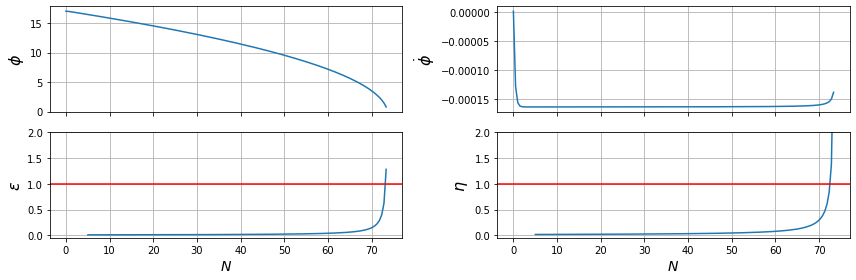

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12, 4), sharex=True)

axs[0, 0].plot(bg.T[0], bg.T[1])
axs[0, 1].plot(bg.T[0], bg.T[2])

axs[1, 0].plot(bg.T[0][10:], eps[10:])
axs[1, 1].plot(bg.T[0][10:], eta[10:])

for ax in axs[1]:
    ax.axhline(1, c="r")
    ax.set_ylim(-0.05, 2)
    ax.set_xlabel("$N$", size=14)
    
labels = [r"$\phi$", r"$\dot{\phi}$", r"$\epsilon$", "$\eta$"]

for ax, lab in zip(axs.flatten(), labels):
    ax.set_ylabel(lab, size=16)
    ax.grid()
    
plt.tight_layout()

## Part 3: Sampling

In [11]:
import os
from pytsa.sampler import setup_sampler
from scipy.stats import uniform, loguniform, norm


# Initialize sampler object
setup = setup_sampler.SamplerMethods(
    chaotic,
    "single_field_example",
    cache_loc=os.path.join(os.getcwd(), "sample_data")  # defaults to ./samplers
)

In [12]:
# Setup analysis hyper parameters, if not set will use defaults at build
setup.set_analysis_params(
    N_sub_evo=3,     # defaults to 6
    N_adiabatic=1,   # defaults to 1
    step_density=10  # defaults to 20
)

In [13]:
# Set priors on initial field values
setup.set_field(
    0,                         # specify which fields the definition corresponds to
    method=uniform(-100, 200)  # define the prior
)

# Set priors on initial field velocty values
setup.set_dot_field(
    0,                    # same as above
    method=norm(0, 1e-3)  # same as above, except, can pass "sr" to use slow-roll equation
)

# Set priors on parameter values (analogous to field definitions)
setup.set_param(
    0,
    method=loguniform(1e-6, 1e-2)  
)

# build sampler
setup.build_sampler()

We can run sampling tasks with apriori or Latin hypercube like methods.

The latter can be useful for exploring the sample distribution functions efficiently with a sparse number of samples.

In [14]:
exec_path = os.path.join(setup.cache_loc, "run.py")
latin_sampler_name = "ex_latin"
apriori_sampler_name = "ex_apriori"

In [15]:
os.system(f"python {exec_path} {latin_sampler_name} --n_samples 500 --latin --ns --entropy 1234")

-- MPI import successful

-- Computing background trajectories


-- Background complete.


-- Computing epsilon data


-- Epsilon complete.


-- Computing eta data


-- Eta complete.


-- Computing mass data


-- Masses complete.


-- Computing observables


-- Observables complete.

Writing results
All done.


0

In [16]:
os.system(f"python {exec_path} {apriori_sampler_name} --n_samples 500 --apriori --ns --entropy 1234")

-- MPI import successful

-- Computing background trajectories


-- Background complete.


-- Computing epsilon data


-- Epsilon complete.


-- Computing eta data


-- Eta complete.


-- Computing mass data


-- Masses complete.


-- Computing observables


-- Observables complete.

Writing results
All done.


0

In [17]:
data_path_latin = os.path.join(setup.cache_loc, latin_sampler_name, f"pandas_{latin_sampler_name}.df")
data_path_apriori = os.path.join(setup.cache_loc, apriori_sampler_name, f"pandas_{apriori_sampler_name}.df")

In [18]:
data_latin = pd.read_pickle(data_path_latin)
data_apriori = pd.read_pickle(data_path_apriori)

In [19]:
# Check data that's avail
data_apriori.columns

Index(['f_0', 'v_0', 'p_0', 'eps_exit', 'eps_end', 'eta_exit', 'eta_end',
       'm_exit_0', 'm_end_0', 'ns', 'running', 'As'],
      dtype='object')

We can now explore the model... e.g. 

Text(0, 0.5, '$m_\\mathrm{end}^2/H^2$')

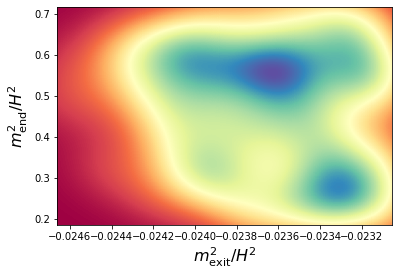

In [28]:
plot_kde(data_latin, "m_exit_0", "m_end_0")
plt.xlabel(r"$m_\mathrm{exit}^2/H^2$", size=16)
plt.ylabel(r"$m_\mathrm{end}^2/H^2$", size=16)

Text(0, 0.5, '$n_s$')

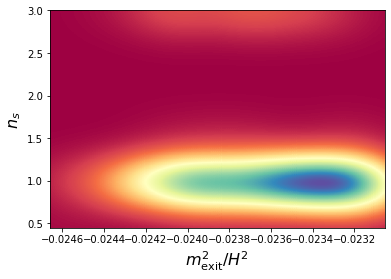

In [30]:
plot_kde(data_latin, "m_exit_0", "ns")
plt.xlabel(r"$m_\mathrm{exit}^2/H^2$", size=16)
plt.ylabel(r"$n_s$", size=16)

Text(0, 0.5, '$n_s$')

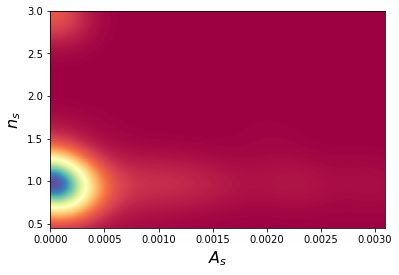

In [35]:
plot_kde(data_latin, "As", "ns")
plt.xlabel(r"$A_s$", size=16)
plt.ylabel(r"$n_s$", size=16)

Text(0, 0.5, '$n_s$')

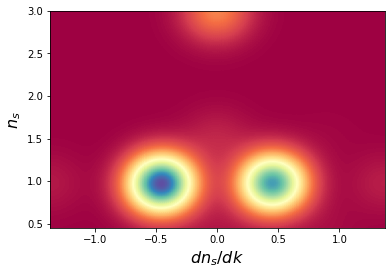

In [37]:
plot_kde(data_latin, "running", "ns")
plt.xlabel(r"$d n_s / d k$", size=16)
plt.ylabel(r"$n_s$", size=16)

Text(0, 0.5, '$\\dot{\\phi}_0$')

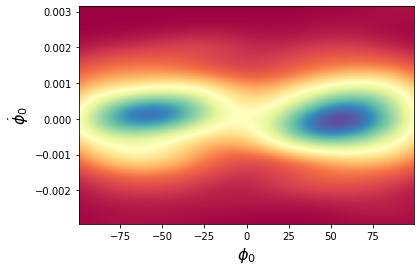

In [41]:
plot_kde(data_latin, "f_0", "v_0")
plt.xlabel(r"$\phi_0$", size=16)
plt.ylabel(r"$\dot{\phi}_0$", size=16)